# Vision Transformer

[An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929v2)

[Vision Transformer for Small-Size Datasets](https://arxiv.org/pdf/2112.13492.pdf) *todo*

[Training Vision Transformers with Only 2040 Images](https://arxiv.org/abs/2201.10728) *todo*



## Model Notes
* P = patch size
* N = number of patches
* transform image from (H,W,C) to (N,P\*\*2 \*C) where
* also prepend a class token
* GeLU activation in MLP layers

## TODO
* fix always predicting same class

In [23]:
# download pretrained weights for Cifar100 trained model
!wget https://storage.googleapis.com/vit_models/augreg/B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz

--2023-01-14 02:46:42--  https://storage.googleapis.com/vit_models/augreg/B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343567142 (328M) [application/octet-stream]
Saving to: ‘B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz’

B_16-i1k-300ep-lr_0 100%[===================>] 327.65M  26.1MB/s    in 14s     

2023-01-14 02:46:57 (23.2 MB/s) - ‘B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz’ saved [343567142/343567142]



In [24]:
# CIFAR100 class names
class_names  = [
    'apple',
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm',
]
print(len(class_names))

100


In [25]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [26]:
transforms = T.Compose([T.ToTensor(), T.Resize(224)])

test_ds = datasets.CIFAR100(
    root='data',
    train=False,
    transform=transforms,
    download=True,
)
test_dl = DataLoader(
    test_ds, batch_size=1, shuffle=True,
)

Files already downloaded and verified


In [36]:
# full base ViT
class VisionTransformer(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.embedding = nn.Conv2d(3, emb_dim, 16, 16, padding='valid')
        # 197 = (224/16) ** 2
        self.pos_embedding = nn.Parameter(torch.ones(1, 197, emb_dim))
        self.cls = nn.Parameter(torch.ones((1, 1, emb_dim)))
        self.ln = nn.LayerNorm(emb_dim)
        self.emb_dim = emb_dim
        self.encoder = nn.Sequential(*[
            nn.TransformerEncoderLayer(emb_dim, 12, 3072, activation=F.gelu,
                                       batch_first=True) for _ in range(12)
        ])
        # self.pre_logits = nn.Parameter(torch.rand(emb_dim))
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        # (bs, seq_len,emb_dim)
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)
        # prepend class embedding token
        # (bs, 1, emb_dim)
        cls_emb = self.cls + torch.zeros(x.shape[0], 1, 1)
        x = torch.cat((cls_emb, x), dim=1)
        x = self.encoder(x + self.pos_embedding)
        x = self.ln(x)
        x = x[:, 0]
        x = self.head(x)
        return x

    def load_from_pretrained(self, path):
        with np.load(path) as data:
            params = self.state_dict()
            params['pos_embedding'] = torch.from_numpy(data['Transformer/posembed_input/pos_embedding'])
            params['cls'] = torch.from_numpy(data['cls'])
            params['embedding.weight'] = torch.from_numpy(data['embedding/kernel']).permute(3, 2, 0, 1)
            params['embedding.bias'] = torch.from_numpy(data['embedding/bias'])
            params['ln.weight'] = torch.from_numpy(data['Transformer/encoder_norm/scale'])
            params['ln.bias'] = torch.from_numpy(data['Transformer/encoder_norm/bias'])
            # params['pre_logits.weight'] = torch.from_numpy(data['pre_logits/kernel']).T
            # params['pre_logits.bias'] = torch.from_numpy(data['pre_logits/bias'])
            params['head.weight'] = torch.from_numpy(data['head/kernel']).T
            params['head.bias'] = torch.from_numpy(data['head/bias'])
            for i in range(12):
                # TODO: I am assuming these attention weights are part of issue?
                #       probably just need to write transformer encoder manually
                #       so that I can know attention weights go where they should
                q = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/kernel']).reshape(768, -1)
                q_bias = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/bias']).reshape(-1)
                k = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/kernel']).reshape(768, -1)
                k_bias = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/bias']).reshape(-1)
                v = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/kernel']).reshape(768, -1)
                v_bias = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/bias']).reshape(-1)
                params[f'encoder.{i}.self_attn.in_proj_weight'] = torch.cat([q,k, v], dim=0)
                params[f'encoder.{i}.self_attn.in_proj_bias'] = torch.cat([q_bias, k_bias, v_bias])
                params[f'encoder.{i}.self_attn.out_proj.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/kernel']).reshape(-1, 768)
                params[f'encoder.{i}.self_attn.out_proj.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/bias'])
                params[f'encoder.{i}.linear1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/kernel']).T
                params[f'encoder.{i}.linear1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/bias'])
                params[f'encoder.{i}.linear2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/kernel']).T
                params[f'encoder.{i}.linear2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/bias'])
                params[f'encoder.{i}.norm1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/scale'])
                params[f'encoder.{i}.norm1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/bias'])
                params[f'encoder.{i}.norm2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/scale']).T
                params[f'encoder.{i}.norm2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/bias'])
            self.load_state_dict(params)

In [44]:
path = 'B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz'
# path = 'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz'
model = VisionTransformer(768, 100)
model.load_from_pretrained(path)

tensor([[-0.9344,  1.0525, -2.5580,  5.5676,  2.2720, -0.5395,  1.3572,  2.3273,
         -2.9378, -1.3514,  0.3068, -1.1027, -1.1754,  1.0177,  1.5607,  2.6056,
         -2.1659, -1.2474,  1.6185,  2.8689, -0.0394,  2.0165,  1.4952, -2.5294,
          0.1566, -1.8240,  1.8465, -0.4419, -1.0130,  1.4246, -0.0429,  2.2779,
          0.9367,  2.9989,  4.1155, -2.0527, -0.4591, -1.7541,  1.4396, -1.1997,
          1.2147, -1.4765,  2.3152,  2.0967,  2.6526,  1.0901,  0.5773, -3.4538,
         -2.1276, -0.7719, -0.0924,  1.3692, -4.0860, -0.7761, -4.2330,  2.0630,
         -2.1803, -0.6639, -2.1861, -0.4474,  0.1820, -3.3162, -2.5275,  0.0369,
          1.1024,  2.2096,  0.4799,  0.9320, -3.3137,  0.2386, -2.3949, -1.5800,
          2.3835,  0.7720,  0.4546,  0.7860, -3.1598,  0.9374,  1.9043,  1.6941,
          2.1497, -1.7835, -1.6743,  0.6044, -0.3533, -1.5473, -0.6159,  1.1399,
          0.2991, -0.5559,  0.2247, -1.8835, -1.3806,  1.1984, -1.9631,  1.5470,
         -1.6026,  1.0614, -

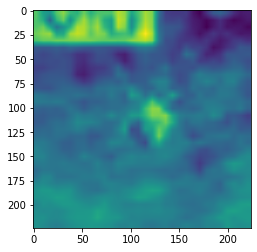

In [45]:
model.eval()
# always predicting cls=3?
for (i, (x, _)) in enumerate(test_dl):
    plt.imshow(x.squeeze(0)[0])
    if i > 0: break
    out = model(x)
    print(out)
    cls = out.argmax(dim=-1).item()
    print(cls, class_names[cls])